# Assignment 2

In [63]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import StandardScaler
import torch
import random
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import mean_squared_error
import os



from torch.optim import SGD, Adam
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau
print('seaborn:', sns.__version__)
print('pandas:', pd.__version__)
print('numpy:', np.__version__)
print('torch:', torch.__version__)

# Define a function to set the seed
def set_seed(seed):
    """
    Sets the seed for reproducibility using numpy and torch.
    """
    # Set seed for numpy
    np.random.seed(seed)
    random.seed(seed)
    print(f"Numpy random seed set to: {seed}")
    
    # Set seed for torch (CPU and GPU)
    torch.manual_seed(seed)  # For CPU
    torch.use_deterministic_algorithms(mode=True)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)  # For current GPU
        torch.cuda.manual_seed_all(seed)  # For all GPUs
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
    print(f"Torch random seed set to: {seed}")

def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

generator = torch.Generator()
generator.manual_seed(0)

# Use the function
seed = 42
set_seed(seed)

seaborn: 0.13.2
pandas: 2.2.3
numpy: 2.1.2
torch: 2.4.1+cpu
Numpy random seed set to: 42
Torch random seed set to: 42


## Task a)

In [64]:
set_seed(seed)
# Splitting the data into train and test set
X, y = fetch_california_housing(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=302)

columns=["MedInc", "HouseAge", "AveRooms", "AveBedrms", "Population", "AveOccup", "Lat", "Long", "MedHouseVal"]
data = pd.DataFrame(data=np.column_stack((X_train, y_train)), columns=columns)

print("Size of the data:")
print(data.shape)

data.head()


Numpy random seed set to: 42
Torch random seed set to: 42
Size of the data:
(15480, 9)


,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Lat,Long,MedHouseVal
0,3.3409,32.0,3.254902,1.009804,177.0,1.735294,33.90,-118.37,2.563
1,4.0000,35.0,4.938095,0.985714,552.0,2.628571,37.71,-122.12,1.679
2,4.1997,17.0,5.732759,1.060345,2866.0,3.088362,38.66,-121.76,1.334
3,5.6163,27.0,6.515670,1.005698,1140.0,3.247863,33.83,-117.87,2.310
4,1.6559,48.0,5.161663,1.000000,1363.0,3.147806,33.99,-118.31,1.014


In [65]:
print("Structure of the data:")
print(data.describe())

Structure of the data:
             MedInc      HouseAge      AveRooms     AveBedrms    Population  \
count  15480.000000  15480.000000  15480.000000  15480.000000  15480.000000   
mean       3.867932     28.634044      5.431607      1.095960   1421.528811   
std        1.899344     12.642321      2.388734      0.427406   1124.197972   
min        0.499900      1.000000      0.846154      0.375000      3.000000   
25%        2.565800     18.000000      4.443769      1.006118    787.000000   
50%        3.528800     29.000000      5.230702      1.048833   1163.000000   
75%        4.744150     37.000000      6.060497      1.099431   1719.250000   
max       15.000100     52.000000    141.909091     25.636364  35682.000000   

           AveOccup           Lat          Long   MedHouseVal  
count  15480.000000  15480.000000  15480.000000  15480.000000  
mean       3.112156     35.634422   -119.569263      2.068206  
std       11.959223      2.138867      2.004747      1.156928  
min      

In [66]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15480 entries, 0 to 15479
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   MedInc       15480 non-null  float64
 1   HouseAge     15480 non-null  float64
 2   AveRooms     15480 non-null  float64
 3   AveBedrms    15480 non-null  float64
 4   Population   15480 non-null  float64
 5   AveOccup     15480 non-null  float64
 6   Lat          15480 non-null  float64
 7   Long         15480 non-null  float64
 8   MedHouseVal  15480 non-null  float64
dtypes: float64(9)
memory usage: 1.1 MB
None


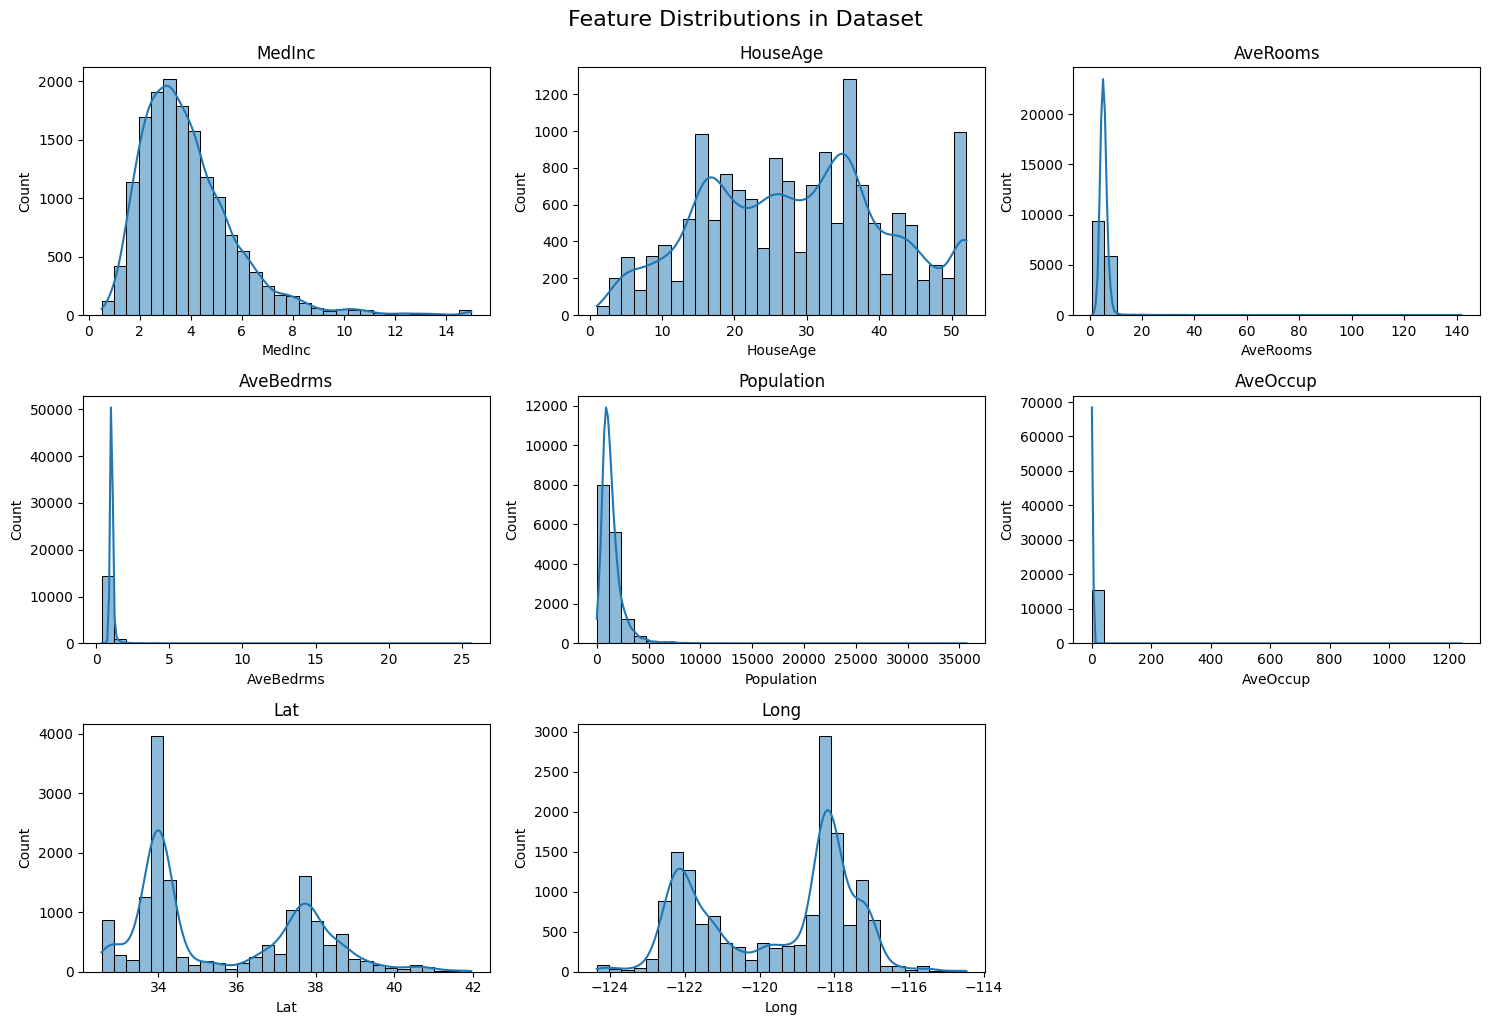

In [67]:
# Plotting feature distributions
def plot_feature_distributions(data, title):
    plt.figure(figsize=(15, 10))
    for i, column in enumerate(data.columns, 1):
        plt.subplot(3, 3, i)
        sns.histplot(data[column], kde=True, bins=30)
        plt.title(column)
    plt.tight_layout()
    plt.suptitle(title, y=1.02, fontsize=16)
    plt.show()

plot_feature_distributions(data.iloc[:, :-1], "Feature Distributions in Dataset")

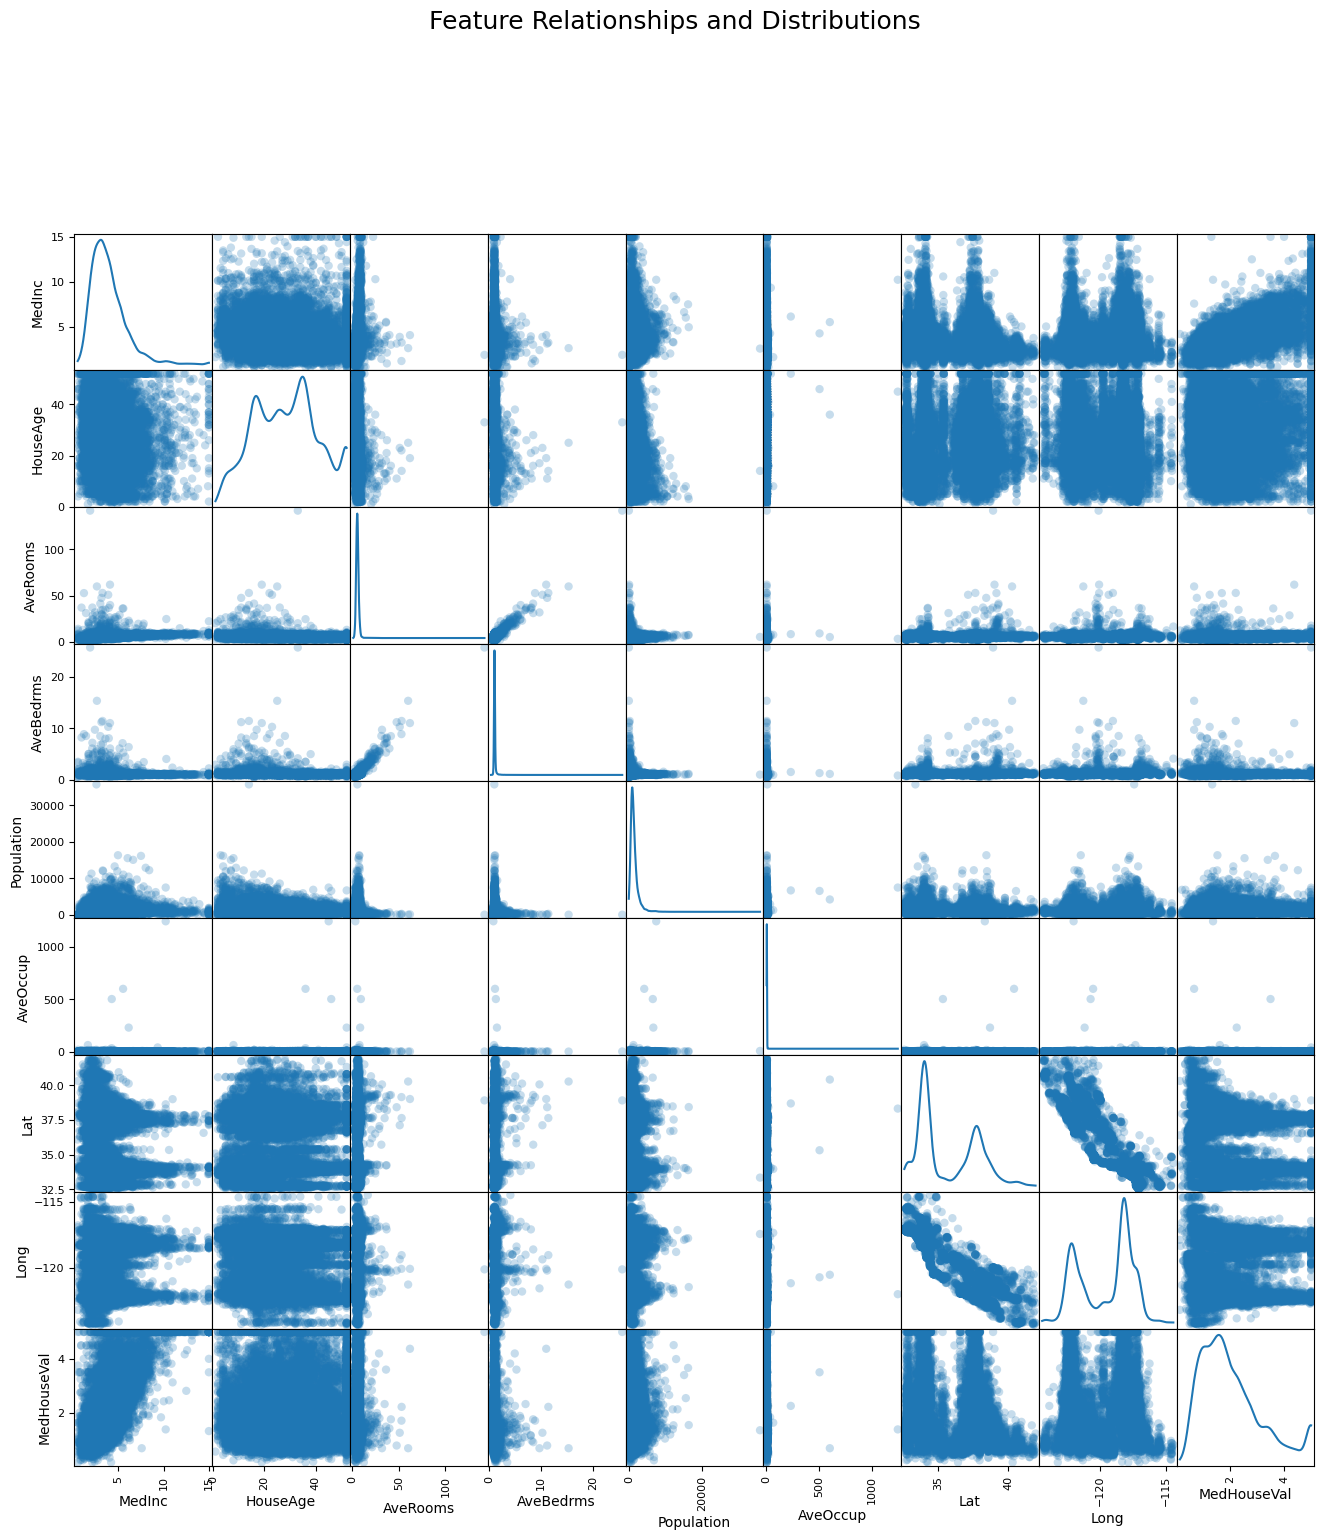

In [68]:
# Scatter plot to observe relationships between features and the target variable.
scatter_matrix = pd.plotting.scatter_matrix(
    data,
    alpha=0.25,
    figsize=(16, 16),
    diagonal="kde",
    marker="o"
)
plt.suptitle("Feature Relationships and Distributions", fontsize=18, y=1.02)
plt.show()

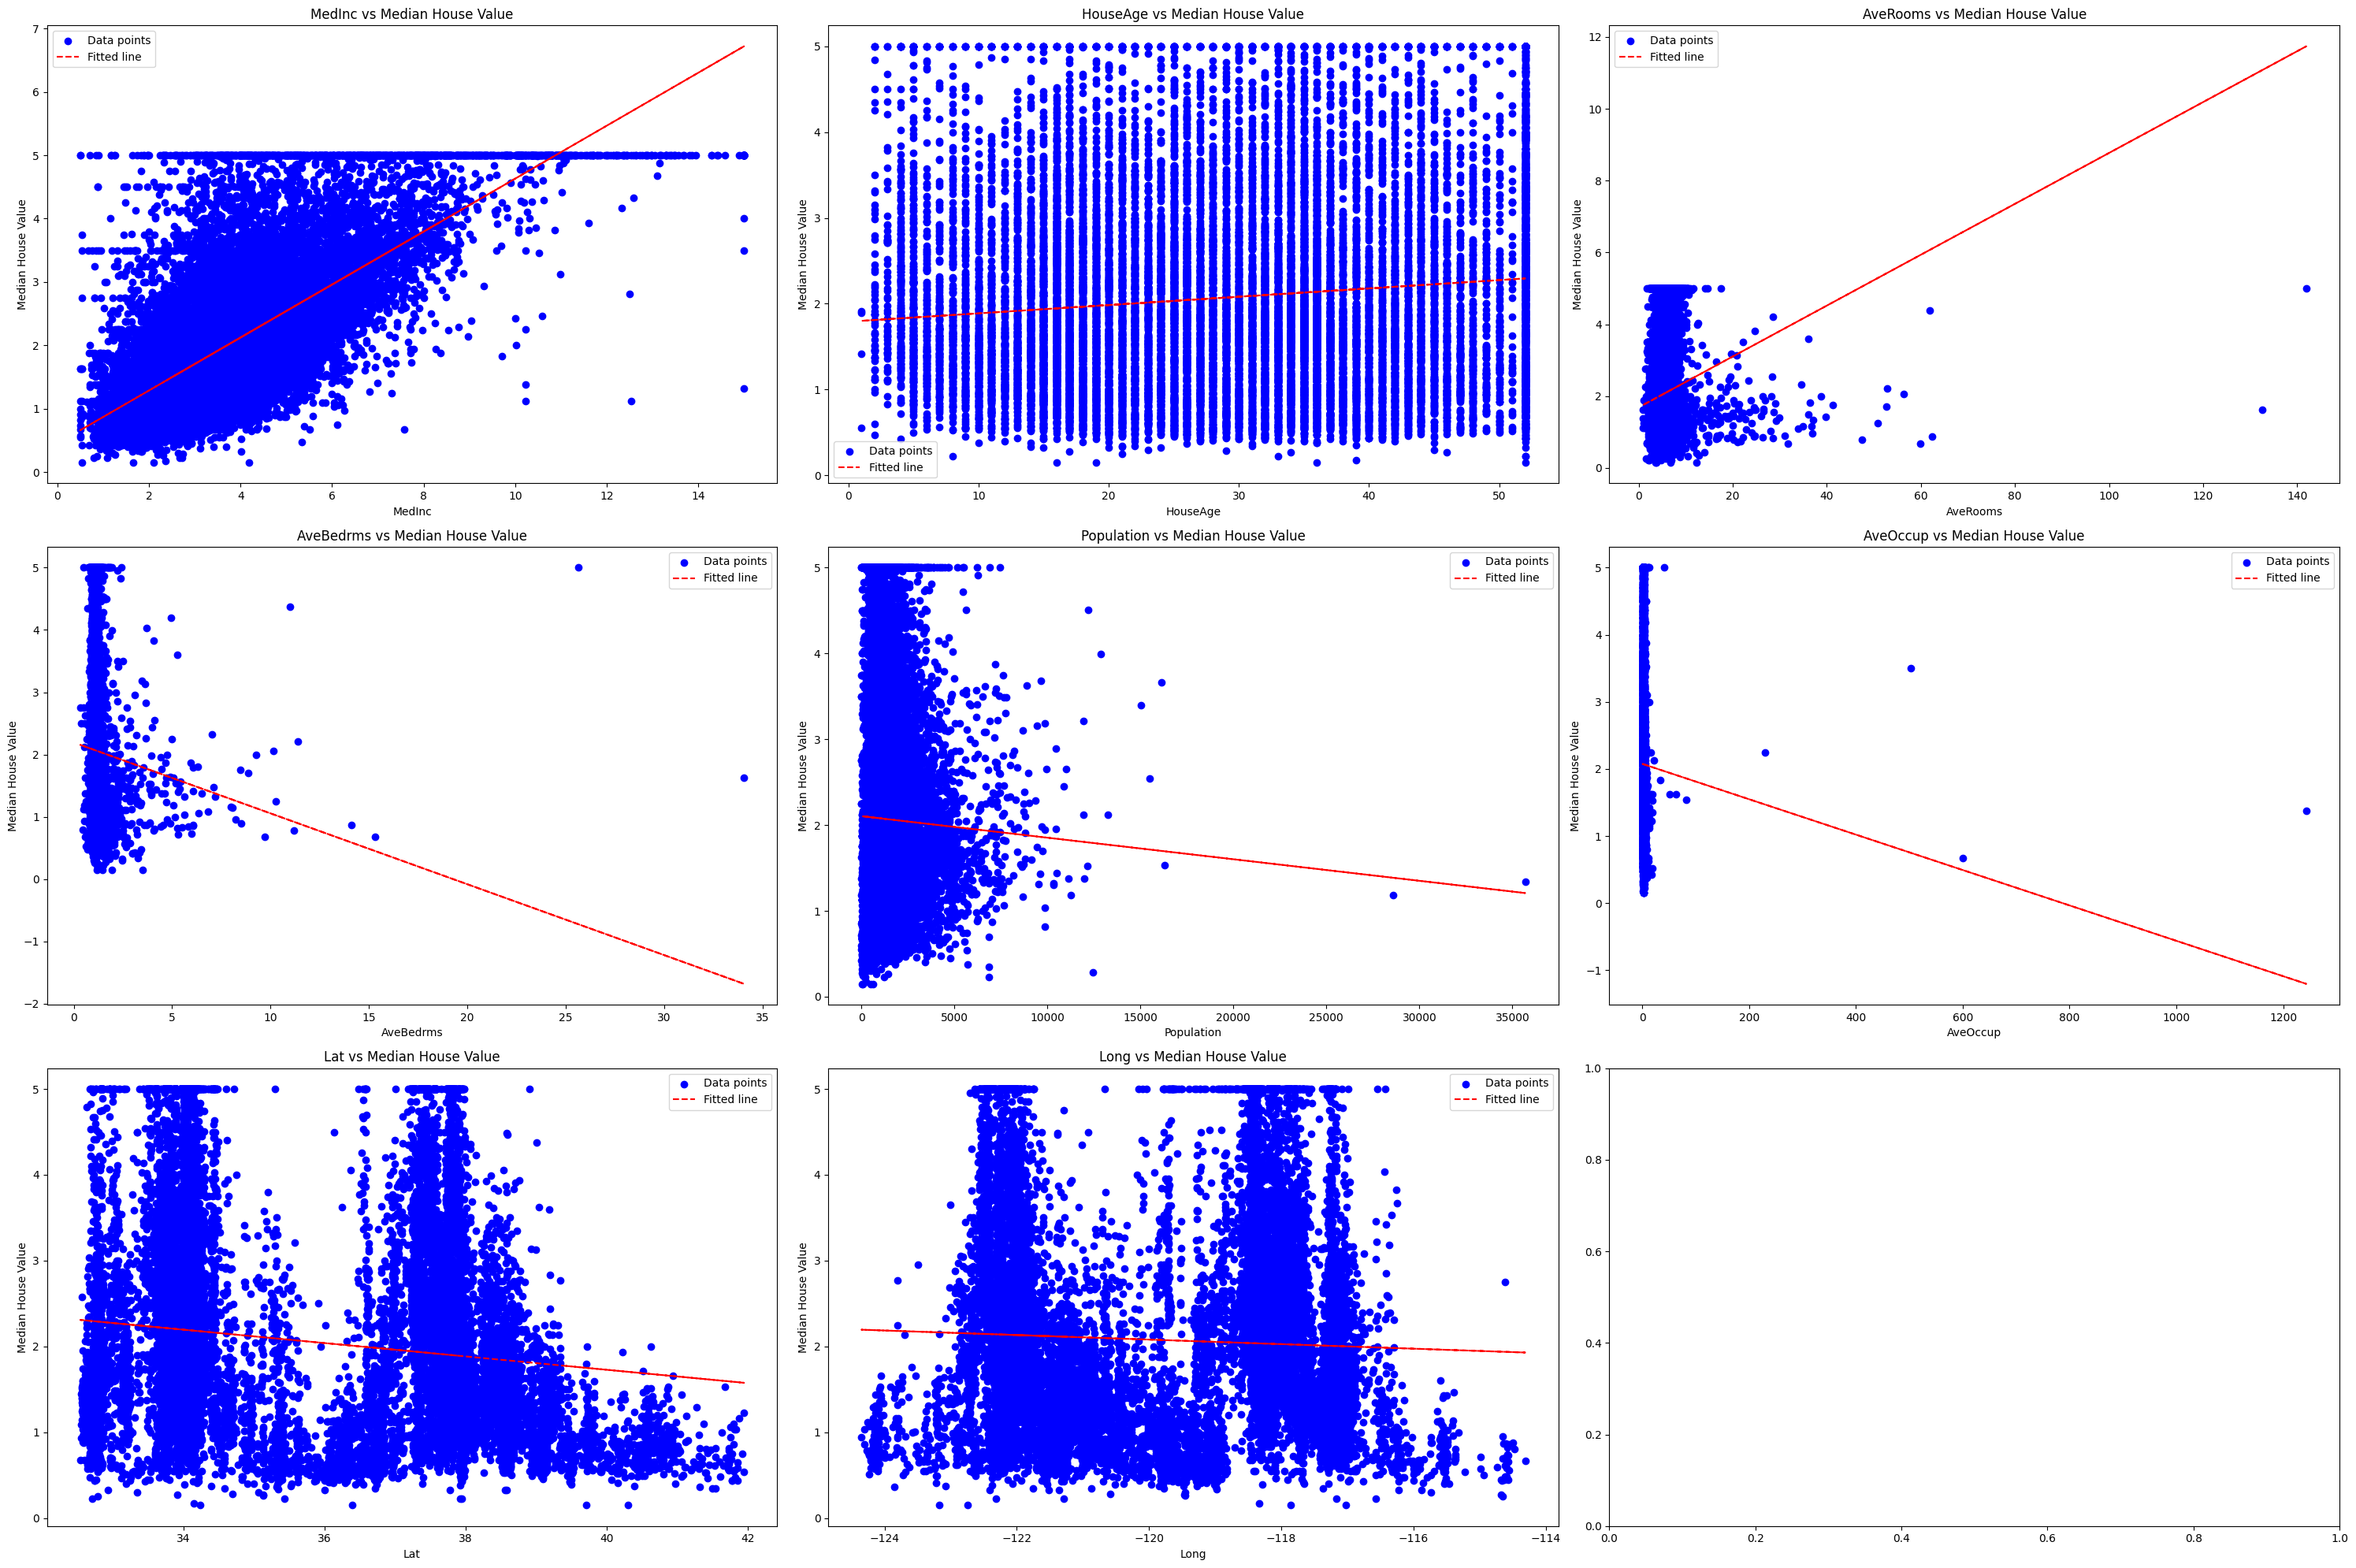

In [69]:
features = ["MedInc", "HouseAge", "AveRooms", "AveBedrms", "Population", "AveOccup", "Lat", "Long"]
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(30, 20))

for index, (axis, feature) in enumerate(zip(axes.flat, features)):
    feature_data = X[:, index] 
    fit_params = np.polyfit(feature_data, y, 1)
    linear_model = np.poly1d(fit_params)

    axis.scatter(feature_data, y, color='blue', label='Data points')
    axis.plot(feature_data, linear_model(feature_data), 'r--', label='Fitted line')

    axis.set_title(f"{feature} vs Median House Value")
    axis.set_xlabel(feature)
    axis.set_ylabel('Median House Value')
    axis.legend()

plt.tight_layout()
plt.show()

In [70]:
# Missing values count
print("Number of missing values")
print("------------------------------")
missing_values = data.isnull().sum()
missing_percentage = (missing_values / len(data)) * 100
missing_info = pd.DataFrame({
    'Missing Values': missing_values,
    'Percentage': missing_percentage
})
print(missing_info)

print("\nNumber of unique values")
print("------------------------------")
unique_values = data.nunique()
print(unique_values)

Number of missing values
------------------------------
             Missing Values  Percentage
MedInc                    0         0.0
HouseAge                  0         0.0
AveRooms                  0         0.0
AveBedrms                 0         0.0
Population                0         0.0
AveOccup                  0         0.0
Lat                       0         0.0
Long                      0         0.0
MedHouseVal               0         0.0

Number of unique values
------------------------------
MedInc         10372
HouseAge          52
AveRooms       14722
AveBedrms      11369
Population      3563
AveOccup       14356
Lat              840
Long             811
MedHouseVal     3602
dtype: int64


Correlation matrix for features
------------------------------
               MedInc  HouseAge  AveRooms  AveBedrms  Population  AveOccup  \
MedInc       1.000000 -0.126398  0.338891  -0.070325    0.006030  0.022880   
HouseAge    -0.126398  1.000000 -0.164742  -0.089941   -0.296191  0.015903   
AveRooms     0.338891 -0.164742  1.000000   0.836048   -0.076527 -0.004385   
AveBedrms   -0.070325 -0.089941  0.836048   1.000000   -0.071595 -0.005768   
Population   0.006030 -0.296191 -0.076527  -0.071595    1.000000  0.074505   
AveOccup     0.022880  0.015903 -0.004385  -0.005768    0.074505  1.000000   
Lat         -0.077792  0.010531  0.113740   0.077687   -0.105442  0.006585   
Long        -0.017599 -0.109259 -0.033491   0.012110    0.098350 -0.001187   
MedHouseVal  0.689480  0.101697  0.163119  -0.049184   -0.023517 -0.021679   

                  Lat      Long  MedHouseVal  
MedInc      -0.077792 -0.017599     0.689480  
HouseAge     0.010531 -0.109259     0.101697  
AveRooms     0.

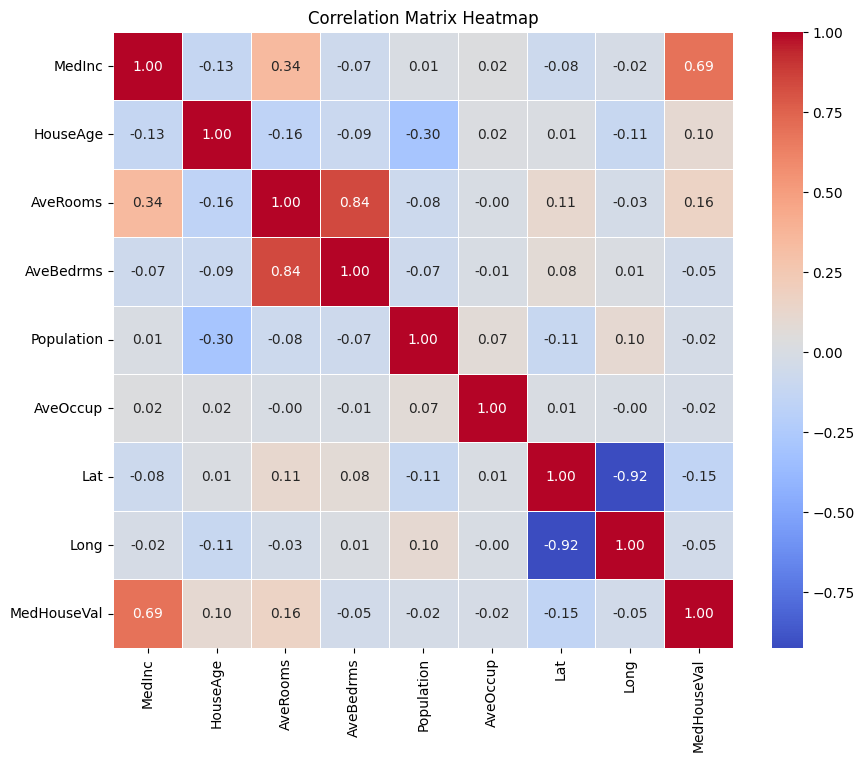

In [71]:
print("Correlation matrix for features")
print("------------------------------")
correlation_matrix = data.corr()
print(correlation_matrix)

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix Heatmap')
plt.show()

In [72]:
print("Number of outliers:")
print("------------------------------")
Q1 = data.quantile(0.25)
Q3 = data.quantile(0.75)
IQR = Q3 - Q1

# Define outliers as values outside 1.5*IQR
outliers = ((data < (Q1 - 1.5 * IQR)) | (data > (Q3 + 1.5 * IQR)))

outliers_count = outliers.sum()
print(outliers_count)

Number of outliers:
------------------------------
MedInc          513
HouseAge          0
AveRooms        384
AveBedrms      1060
Population      908
AveOccup        532
Lat               0
Long              0
MedHouseVal     793
dtype: int64


In [73]:
set_seed(seed)
# Preprocessing
# Normalization
scaler = StandardScaler()
x_train = scaler.fit_transform(X_train)
x_test = scaler.transform(X_test)

# Split X_train to validation and train data
X_new_train, X_val, y_new_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=302)

Numpy random seed set to: 42
Torch random seed set to: 42


## Task b)

In [74]:
set_seed(seed)
# Convert to PyTorch tensors
X_new_train = torch.tensor(X_new_train).float()
y_new_train = torch.tensor(y_new_train).view(-1, 1).float()

X_val = torch.tensor(X_val).float()
y_val = torch.tensor(y_val).view(-1, 1).float()

X_test = torch.tensor(x_test).float()
y_test = torch.tensor(y_test).view(-1, 1).float()

Numpy random seed set to: 42
Torch random seed set to: 42


In [80]:
set_seed(seed)
generator = torch.Generator()
generator.manual_seed(0)

def train_with_batch_size(model_fn, batch_size, num_epochs=200, patience=10):
    # Adjust learning rate based on batch size
    base_lr = 0.0001
    adjusted_lr = base_lr * (batch_size ** 0.5)

    train_dataset = TensorDataset(X_new_train, y_new_train)
    train_iter = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0,worker_init_fn=seed_worker,generator=generator)

    val_dataset = TensorDataset(X_val, y_val)
    val_iter = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0,worker_init_fn=seed_worker,generator=generator)

    model = model_fn()
    criterion = nn.MSELoss()
    optimizer = torch.optim.RMSprop(model.parameters(), lr=adjusted_lr)
    
    train_losses = []
    val_losses = []
    
    # Early stopping variables
    best_val_loss = float('inf')
    best_train_loss = None 
    epochs_no_improve = 0
    early_stop = False
    
    for epoch in range(num_epochs):
        if early_stop:
            print(f"Early stopping at epoch {epoch}")
            break

        running_train_loss = 0.0
        model.train()
        
        # Training loop
        for inputs, labels in train_iter:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            running_train_loss += loss.item()
        
        # Validation loop
        model.eval()
        running_val_loss = 0.0
        with torch.no_grad():
            for inputs, labels in val_iter:
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                running_val_loss += loss.item()
        
        # Calculate averate train and validation losses
        avg_train_loss = running_train_loss / len(train_iter)
        avg_val_loss = running_val_loss / len(val_iter)
        
        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)

        # Check for early stopping
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            best_train_loss = avg_train_loss
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
        
        if epochs_no_improve >= patience:
            early_stop = True
    
    # Evaluate the model on test data
    model.eval()
    with torch.no_grad():
        test_outputs = model(X_test)
        test_rmse = np.sqrt(mean_squared_error(test_outputs.numpy(), y_test.numpy()))

    return best_val_loss, test_rmse, best_train_loss

set_seed(seed)
# We will use a fixed model to see if its loss changes with different batch sizes

def init_weights(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.normal_(m.weight, mean=0, std=0.01)  # Manual initialization of weights
        m.bias.data.fill_(0.0001)  # Bias initialization

def create_model():
    model = nn.Sequential(
        nn.Linear(8, 100),
        nn.ReLU(),
        nn.Linear(100, 50),
        nn.ReLU(),
        nn.Linear(50, 10),
        nn.ReLU(),
        nn.Linear(10, 1)
    )
    
    # Apply custom weight initialization
    model.apply(init_weights)
    
    return model

# Batch sizes to test
batch_sizes = [16, 32, 50, 64, 128, 256]
results = []

# Running experiments on every batch size
for batch_size in batch_sizes:
    print(f"Testing batch size: {batch_size}")
    val_loss, test_rmse, train_loss = train_with_batch_size(create_model, batch_size)
    results.append({'Batch Size': batch_size,'Train Loss': train_loss, 'Validation Loss': val_loss, 'Test RMSE': test_rmse })
    print(f"Batch Size: {batch_size}, Train Loss: {train_loss:.3f}, Validation Loss: {val_loss:.3f}, Test RMSE: {test_rmse:.3f}")

results_df = pd.DataFrame(results)
print(results_df)

best_result = results_df.loc[results_df['Validation Loss'].idxmin()]
print(f"Best Batch Size: {best_result['Batch Size']} with "
      f"Validation Loss: {best_result['Validation Loss']:.3f}, "
      f"Test RMSE: {best_result['Test RMSE']:.3f}, "
      f"Train Loss: {best_result['Train Loss']:.3f}")

Numpy random seed set to: 42
Torch random seed set to: 42
Numpy random seed set to: 42
Torch random seed set to: 42
Testing batch size: 16
Early stopping at epoch 107
Batch Size: 16, Train Loss: 0.263, Validation Loss: 0.294, Test RMSE: 0.535
Testing batch size: 32
Early stopping at epoch 96
Batch Size: 32, Train Loss: 0.277, Validation Loss: 0.303, Test RMSE: 0.535
Testing batch size: 50
Early stopping at epoch 169
Batch Size: 50, Train Loss: 0.239, Validation Loss: 0.275, Test RMSE: 0.519
Testing batch size: 64
Early stopping at epoch 119
Batch Size: 64, Train Loss: 0.260, Validation Loss: 0.294, Test RMSE: 0.545
Testing batch size: 128
Early stopping at epoch 132
Batch Size: 128, Train Loss: 0.271, Validation Loss: 0.300, Test RMSE: 0.534
Testing batch size: 256
Early stopping at epoch 147
Batch Size: 256, Train Loss: 0.281, Validation Loss: 0.316, Test RMSE: 0.554
   Batch Size  Train Loss  Validation Loss  Test RMSE
0          16    0.262786         0.293824   0.534579
1          

### We will choose 50 as the batch size since it provided the lowest Validation Loss and Test RMSE.

In [81]:
set_seed(seed)
generator = torch.Generator()
generator.manual_seed(0)

batch_size = 50
train_dataset = TensorDataset(X_new_train, y_new_train)
train_iter = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0,
    worker_init_fn=seed_worker,
    generator=generator)

val_dataset = TensorDataset(X_val, y_val)
val_iter = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0,
    worker_init_fn=seed_worker,
    generator=generator)

# Architectures to test
architectures = [
    [8, 50, 1],
    [8, 100, 50, 1],
    [8, 64, 32, 16, 1],
    [8, 100, 50, 10, 1],
    [8, 32, 32, 16, 1]
]

# Function to create the model
def init_weights(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.normal_(m.weight, mean=0, std=0.01)  # Manual initialization of weights and bias for reproducability
        m.bias.data.fill_(0.0001)

def create_model(architecture):
    layers = []
    for i in range(len(architecture) - 1):
        layer = nn.Linear(architecture[i], architecture[i + 1])
        layers.append(layer)
        if i < len(architecture) - 2:
            layers.append(nn.ReLU())
    model = nn.Sequential(*layers)
    model.apply(init_weights)   
    return model

# Loss function
criterion = nn.MSELoss()

# Training function with validation loss tracking
def train(model_inp, num_epochs=200):
    adjusted_lr = 0.0001 * (batch_size ** 0.5)
    optimizer = torch.optim.RMSprop(model_inp.parameters(), lr=adjusted_lr)
    
    train_losses = []
    val_losses = []
    best_val_loss = float('inf')
    best_train_loss = None 
    
    for epoch in range(num_epochs):
        running_train_loss = 0.0
        model_inp.train()
        
        # Training loop
        for inputs, labels in train_iter:
            outputs = model_inp(inputs)
            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            running_train_loss += loss.item()
        
        # Validation loop
        model_inp.eval()
        running_val_loss = 0.0
        with torch.no_grad():
            for inputs, labels in val_iter:
                outputs = model_inp(inputs)
                loss = criterion(outputs, labels)
                running_val_loss += loss.item()
        
        # Calculate the average losses
        avg_train_loss = running_train_loss / len(train_iter)
        avg_val_loss = running_val_loss / len(val_iter)
        
        # Store the losses
        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)

        # Track the best epoch based on validation loss
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            best_train_loss = avg_train_loss
            best_epoch = epoch

        if epoch % 20 == 0:
            print(f"Epoch [{epoch + 1}/{num_epochs}] Train Loss: {avg_train_loss:.3f}, Validation Loss: {avg_val_loss:.3f}")

    return train_losses, val_losses, best_train_loss, best_val_loss, best_epoch

# Save the model to the 'models' folder
def save_model(model_obj, model_path):
    torch.save(model_obj.state_dict(), model_path)

model_dir = "models"
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

train_val_loss_data = []
best_loss_data = []

for idx, architecture in enumerate(architectures):
    print(f"\nTraining model {idx + 1} with architecture: {architecture}")

    # Create model
    model = create_model(architecture)
    model.train()
    
    # Train the model
    model_path = os.path.join(model_dir, f"model_architecture_{idx + 1}.pth")
    train_losses, val_losses, best_train_loss, best_val_loss_at_epoch, best_epoch = train(model, num_epochs=200)
    
    # Save the model
    save_model(model, model_path)
    
    # Collect the final train and validation loss
    for epoch in range(200):
        train_val_loss_data.append({
            'Model': f"Model_{idx + 1}",
            'Epoch': epoch + 1,  # Epoch starts from 1, not 0
            'Train Loss': train_losses[epoch],  # Loss for the current epoch
            'Validation Loss': val_losses[epoch]  # Validation loss for the current epoch
        })

    # Collect the best train loss, best validation loss, and best epoch
    best_loss_data.append({
        'Model': f"Model_{idx + 1}",
        'Best Train Loss': best_train_loss,
        'Best Validation Loss': best_val_loss_at_epoch,
        'Best Epoch': best_epoch
    })

    # Evaluate the model on the test set
    model.eval()
    with torch.no_grad():
        outputs = model(X_test)
        err = np.sqrt(mean_squared_error(outputs.numpy(), y_test.numpy()))
        print(f"Model {idx + 1} RMSE on test set: {err:.3f}")

train_val_loss_summary = pd.DataFrame(train_val_loss_data)
best_loss_summary = pd.DataFrame(best_loss_data)

# Display both summaries
print("\nTraining and Validation Loss Summary:")
print(train_val_loss_summary)

print("\nBest Loss and Epoch Summary:")
print(best_loss_summary)

Numpy random seed set to: 42
Torch random seed set to: 42

Training model 1 with architecture: [8, 50, 1]
Epoch [1/200] Train Loss: 1.382, Validation Loss: 0.658
Epoch [21/200] Train Loss: 0.377, Validation Loss: 0.412
Epoch [41/200] Train Loss: 0.360, Validation Loss: 0.393
Epoch [61/200] Train Loss: 0.354, Validation Loss: 0.391
Epoch [81/200] Train Loss: 0.350, Validation Loss: 0.384
Epoch [101/200] Train Loss: 0.344, Validation Loss: 0.377
Epoch [121/200] Train Loss: 0.337, Validation Loss: 0.370
Epoch [141/200] Train Loss: 0.333, Validation Loss: 0.366
Epoch [161/200] Train Loss: 0.333, Validation Loss: 0.362
Epoch [181/200] Train Loss: 0.329, Validation Loss: 0.362
Model 1 RMSE on test set: 0.585

Training model 2 with architecture: [8, 100, 50, 1]
Epoch [1/200] Train Loss: 0.742, Validation Loss: 0.490
Epoch [21/200] Train Loss: 0.378, Validation Loss: 0.413
Epoch [41/200] Train Loss: 0.325, Validation Loss: 0.360
Epoch [61/200] Train Loss: 0.298, Validation Loss: 0.326
Epoch [8

### Chosen Architecture: `[8, 64, 32, 16, 1]` due to lowest validation loss
This architecture represents a feedforward neural network with the following layers:

- **Input Layer:** 8 neurons
- **Hidden Layer 1:** 64 neurons
- **Hidden Layer 2:** 32 neurons
- **Hidden Layer 3:** 16 neurons
- **Output Layer:** 1 neuron

This structure defines the number of neurons in each layer, from the input to the output, with three hidden layers in between.

It was chosen due to the lowest Root Mean Squared Error (RMSE) on test set: 0.511.

For the loss function we have used Mean Squared Error (MSE). The optimizer is Adam and the learning rate is adjusted depending on the batch size as follows: 0.0001 * (batch_size ** 0.5).

For the activation function we have utilized ReLU. However, the output layer does not have an activation function, since we expect a continuous value in the regression task.

### Task c)

In [82]:
set_seed(seed)
generator = torch.Generator()
generator.manual_seed(0)

# **Batch Size**
batch_size = 50

# **Number of Epochs**
num_epochs = 200

# **Architecture**
architecture = [8, 64, 32, 16, 1]

# Ensure the directory for saving models exists
model_save_dir = "models_optimizer"
if not os.path.exists(model_save_dir):
    os.makedirs(model_save_dir)

# Define the dataset and data loaders
train_dataset = TensorDataset(X_new_train, y_new_train)
train_iter = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0,
    worker_init_fn=seed_worker,
    generator=generator)

val_dataset = TensorDataset(X_val, y_val)
val_iter = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0,
    worker_init_fn=seed_worker,
    generator=generator)

# Function to create the model
def init_weights(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.normal_(m.weight, mean=0, std=0.01)  # Manual initialization of weights and bias for reproducability
        m.bias.data.fill_(0.0001)

def create_model(architecture):
    layers = []
    for i in range(len(architecture) - 1):
        layer = nn.Linear(architecture[i], architecture[i + 1])
        layers.append(layer)
        if i < len(architecture) - 2:
            layers.append(nn.ReLU())
    model = nn.Sequential(*layers)
    model.apply(init_weights)   
    return model

# Loss function
criterion = nn.MSELoss()

# Gradient clipping value
max_grad_norm = 5.0

# Define optimizers with multiple learning rates
optimizers = [
    {"name": "SGD", "optimizer": SGD, "params": {"lr": lr}}
    for lr in [1e-3, 1e-2, 1e-1]
] + [
    {"name": "SGD_Momentum", "optimizer": SGD, "params": {"lr": lr, "momentum": 0.9}}
    for lr in [1e-3, 1e-2, 1e-1]
] + [
    {"name": "Adam", "optimizer": Adam, "params": {"lr": lr}}
    for lr in [1e-3, 1e-2, 1e-1]
]

# Schedulers
schedulers = [
    {"name": "None", "scheduler": None, "params": {}},
    {"name": "StepLR", "scheduler": StepLR, "params": {"step_size": 10, "gamma": 0.1}},
    {"name": "ReduceLROnPlateau", "scheduler": ReduceLROnPlateau, "params": {"factor": 0.5, "patience": 5}},
]

# Early stopping function
class EarlyStopping:
    def __init__(self, patience=40, delta=0.001, save_path="best_model.pth"):
        """
        Initializes early stopping.
        Args:
        - patience (int): How many epochs to wait before stopping when no improvement.
        - delta (float): Minimum change in the monitored metric to qualify as improvement.
        - save_path (str): Path to save the best model.
        """
        self.patience = patience
        self.delta = delta
        self.save_path = save_path
        self.best_loss = float("inf")
        self.counter = 0
        self.early_stop = False
        self.best_epoch = 0  # Track the epoch of the best validation loss

    def __call__(self, val_loss, model, epoch):
        """
        Checks if training should stop.
        Args:
        - val_loss (float): Current validation loss.
        - model (nn.Module): The model to save when improvement occurs.
        - epoch (int): Current epoch number.
        """
        if val_loss < self.best_loss - self.delta:
            self.best_loss = val_loss
            self.counter = 0
            self.best_epoch = epoch
            torch.save(model.state_dict(), self.save_path)
            print(f"Validation loss improved to {self.best_loss:.4f}. Saving model at epoch {epoch + 1}.")
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
                print(f"Early stopping triggered at epoch {epoch + 1}. Best validation loss was {self.best_loss:.4f} at epoch {self.best_epoch + 1}.")

# Training and validation function with best value tracking
def train_and_validate(
    model, train_iter, val_iter, num_epochs, optimizer_cls=None, optimizer_params=None, scheduler_cls=None, scheduler_params=None, early_stopping=None
):
    optimizer = optimizer_cls(model.parameters(), **optimizer_params)
    scheduler = scheduler_cls(optimizer, **scheduler_params) if scheduler_cls else None

    train_losses, val_losses = [], []

    # Initialize best values
    best_val_loss = float("inf")
    best_train_loss = None
    best_epoch = 0
    best_model_state = None  # To store the state dict of the best model

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_train_loss = 0.0
        for inputs, labels in train_iter:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
            optimizer.step()
            running_train_loss += loss.item()

        avg_train_loss = running_train_loss / len(train_iter)
        train_losses.append(avg_train_loss)

        # Validation phase
        model.eval()
        running_val_loss = 0.0
        with torch.no_grad():
            for inputs, labels in val_iter:
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                if not torch.isfinite(loss):
                    print(f"NaN detected in validation loss at epoch {epoch + 1}. Skipping...")
                    loss = torch.tensor(float("inf"))  # Assign high loss value
                running_val_loss += loss.item()

        avg_val_loss = running_val_loss / len(val_iter)
        val_losses.append(avg_val_loss)

        # Update the best model and its state
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            best_train_loss = avg_train_loss
            best_epoch = epoch + 1
            best_model_state = model.state_dict()  # Save the best model state
            print(f"Validation loss improved to {best_val_loss:.4f} at epoch {epoch + 1}.")

        # Update scheduler if applicable
        if scheduler:
            if isinstance(scheduler, ReduceLROnPlateau):
                scheduler.step(avg_val_loss)
            else:
                scheduler.step()

        # Check early stopping
        if early_stopping:
            early_stopping(avg_val_loss, model, epoch)
            if early_stopping.early_stop:
                print(f"Early stopping triggered. Best validation loss: {best_val_loss:.4f}")
                break

        # Print intermediate results every 10 epochs
        if epoch % 10 == 0 or epoch == num_epochs - 1:
            print(f"Epoch {epoch + 1}/{num_epochs} - Train Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}")

    return train_losses, val_losses, best_train_loss, best_val_loss, best_epoch, best_model_state

# Run experiments for each optimizer and scheduler
results = []
for opt_config in optimizers:
    for sched_config in schedulers:
        print(f"=== Training with Optimizer: {opt_config['name']}, LR: {opt_config['params']['lr']}, Scheduler: {sched_config['name']} ===")
        model = create_model(architecture)
        
        # Initialize early stopping
        early_stopping = EarlyStopping(patience=20, delta=0.001)
        
        train_losses, val_losses, best_train_loss, best_val_loss, best_epoch, best_model_state = train_and_validate(
            model,
            train_iter,
            val_iter,
            num_epochs,
            optimizer_cls=opt_config["optimizer"],
            optimizer_params=opt_config["params"],
            scheduler_cls=sched_config["scheduler"],
            scheduler_params=sched_config["params"],
            early_stopping=early_stopping
        )
        print(f"Best Train Loss: {best_train_loss:.4f}, Best Validation Loss: {best_val_loss:.4f} at Epoch {best_epoch}\n")
        
        # Save the best model state to a file
        model_save_path = f"{model_save_dir}/best_model_{opt_config['name']}_LR{opt_config['params']['lr']}_{sched_config['name']}.pth"
        torch.save(best_model_state, model_save_path)
        print(f"Best model saved to {model_save_path}")

        # Save results
        results.append({
            "Optimizer": opt_config["name"],
            "Learning Rate": opt_config["params"]["lr"],
            "Scheduler": sched_config["name"],
            "Best Train Loss": best_train_loss,
            "Best Val Loss": best_val_loss,
            "Best Epoch": best_epoch,
            "Model Path": model_save_path
        })

# Store results in a DataFrame
results_df = pd.DataFrame(results)

# Save results as a CSV file
results_csv_path = os.path.join(model_save_dir, "results_summary.csv")
results_df.to_csv(results_csv_path, index=False)

# Display the final results
print("=== Optimizer and Scheduler Comparison Results ===")
print(results_df)

Numpy random seed set to: 42
Torch random seed set to: 42
=== Training with Optimizer: SGD, LR: 0.001, Scheduler: None ===
Validation loss improved to 3.0233 at epoch 1.
Validation loss improved to 3.0233. Saving model at epoch 1.
Epoch 1/200 - Train Loss: 4.0307, Validation Loss: 3.0233
Validation loss improved to 2.0033 at epoch 2.
Validation loss improved to 2.0033. Saving model at epoch 2.
Validation loss improved to 1.6176 at epoch 3.
Validation loss improved to 1.6176. Saving model at epoch 3.
Validation loss improved to 1.4700 at epoch 4.
Validation loss improved to 1.4700. Saving model at epoch 4.
Validation loss improved to 1.4123 at epoch 5.
Validation loss improved to 1.4123. Saving model at epoch 5.
Validation loss improved to 1.3898 at epoch 6.
Validation loss improved to 1.3898. Saving model at epoch 6.
Validation loss improved to 1.3805 at epoch 7.
Validation loss improved to 1.3805. Saving model at epoch 7.
Validation loss improved to 1.3764 at epoch 8.
Validation loss 

## Task d)

In [83]:
set_seed(seed)
generator = torch.Generator()
generator.manual_seed(0)

# Retraining the best model to obtain the validation and train losses for the plot
train_dataset = TensorDataset(X_new_train, y_new_train)
train_iter = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0,
    worker_init_fn=seed_worker,
    generator=generator)

val_dataset = TensorDataset(X_val, y_val)
val_iter = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0,
    worker_init_fn=seed_worker,
    generator=generator)

batch_size = 50
num_epochs = 200
architecture = [8, 64, 32, 16, 1]

model_save_dir = "models_optimizer"
if not os.path.exists(model_save_dir):
    os.makedirs(model_save_dir)

criterion = nn.MSELoss()
max_grad_norm = 5.0

optimizer_config = {"name": "Adam", "optimizer": Adam, "params": {"lr": 1e-2}}
scheduler_config = {"name": "ReduceLROnPlateau", "scheduler": ReduceLROnPlateau, "params": {"factor": 0.5, "patience": 5}}

results = []
train_losses = []
val_losses = []
best_train_loss = []
best_val_loss = []
best_epoch = []
best_model_state = []
        
model = create_model(architecture)
early_stopping = EarlyStopping(patience=20, delta=0.001)

train_losses, val_losses, best_train_loss, best_val_loss, best_epoch, best_model_state = train_and_validate(
    model,
    train_iter,
    val_iter,
    num_epochs,
    optimizer_cls=optimizer_config["optimizer"],
    optimizer_params=optimizer_config["params"],
    scheduler_cls=scheduler_config["scheduler"],
    scheduler_params=scheduler_config["params"],
    early_stopping=early_stopping
)

print(f"Best Train Loss: {best_train_loss:.4f}, Best Validation Loss: {best_val_loss:.4f} at Epoch {best_epoch}\n")

model_path = f"{model_save_dir}/best_model_{opt_config['name']}_LR{opt_config['params']['lr']}_{sched_config['name']}.pth"
print(f"Best model: {model_save_path}")

# Save results
results.append({
    "Optimizer": opt_config["name"],
    "Learning Rate": opt_config["params"]["lr"],
    "Scheduler": sched_config["name"],
    "Best Train Loss": best_train_loss,
    "Best Val Loss": best_val_loss,
    "Best Epoch": best_epoch,
    "Model Path": model_save_path
})

results_df1 = pd.DataFrame(results)
print(results_df1)

Numpy random seed set to: 42
Torch random seed set to: 42
Validation loss improved to 0.4440 at epoch 1.
Validation loss improved to 0.4440. Saving model at epoch 1.
Epoch 1/200 - Train Loss: 0.7546, Validation Loss: 0.4440
Validation loss improved to 0.4341 at epoch 2.
Validation loss improved to 0.4341. Saving model at epoch 2.
Validation loss improved to 0.4288 at epoch 3.
Validation loss improved to 0.4288. Saving model at epoch 3.
Validation loss improved to 0.4168 at epoch 4.
Validation loss improved to 0.4168. Saving model at epoch 4.
Validation loss improved to 0.4074 at epoch 5.
Validation loss improved to 0.4074. Saving model at epoch 5.
Validation loss improved to 0.3834 at epoch 9.
Validation loss improved to 0.3834. Saving model at epoch 9.
Validation loss improved to 0.3705 at epoch 11.
Validation loss improved to 0.3705. Saving model at epoch 11.
Epoch 11/200 - Train Loss: 0.3683, Validation Loss: 0.3705
Validation loss improved to 0.3689 at epoch 12.
Validation loss imp

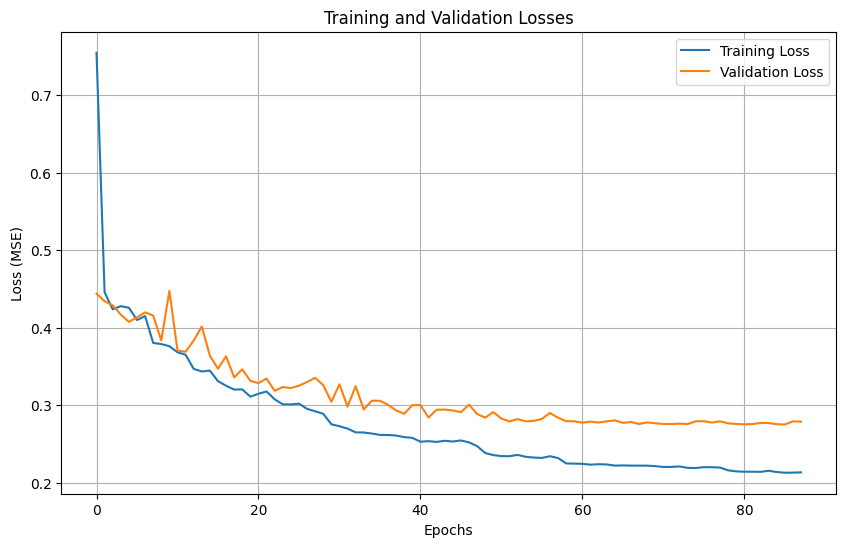

In [84]:
# Plot Training and Validation Losses
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label="Training Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss (MSE)")
plt.title("Training and Validation Losses")
plt.legend()
plt.grid()
plt.show()

In [85]:
set_seed(seed)
generator = torch.Generator()
generator.manual_seed(0)

# Combine training and validation data
X_combined = torch.cat([X_new_train, X_val], dim=0)
y_combined = torch.cat([y_new_train, y_val], dim=0)

combined_dataset = TensorDataset(X_combined, y_combined)
combined_iter = DataLoader(combined_dataset, batch_size=batch_size, shuffle=True, num_workers=0,
    worker_init_fn=seed_worker,
    generator=generator)

# Initialize and train the final model
batch_size = 50
num_epochs = 200
architecture = [8, 64, 32, 16, 1]
max_grad_norm = 5.0

final_model = create_model(architecture)
final_optimizer = Adam(final_model.parameters(), lr=1e-2)
final_criterion = nn.MSELoss()

schedulers = [
    {"name": "ReduceLROnPlateau", "scheduler": ReduceLROnPlateau, "params": {"factor": 0.5, "patience": 5}},
]
scheduler = schedulers[0]["scheduler"](final_optimizer, **schedulers[0]["params"])

final_train_losses = []
print("Final model training started.")
for epoch in range(num_epochs):
    final_model.train()
    epoch_loss = 0
    for X_batch, y_batch in combined_iter:
        final_optimizer.zero_grad()
        y_pred = final_model(X_batch)
        loss = final_criterion(y_pred, y_batch)
        loss.backward()
        nn.utils.clip_grad_norm_(final_model.parameters(), max_grad_norm)
        final_optimizer.step()
        epoch_loss += loss.item()

    final_train_losses.append(epoch_loss / len(combined_iter))
    scheduler.step(epoch_loss / len(combined_iter))
    
    if epoch % 10 == 0 or epoch == num_epochs - 1:
        print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {epoch_loss / len(combined_iter):.4f}")

# Save the final model
torch.save(final_model.state_dict(), f"{model_save_dir}/final_model.pth")
print("Final model training completed.")

# Test the model
final_model.eval()
y_test_pred = None
test_loss = None
with torch.no_grad():
    y_test_pred = final_model(X_test)
    test_loss = final_criterion(y_test_pred, y_test).item()

print(f"Final Test Loss: {test_loss:.4f}")


Numpy random seed set to: 42
Torch random seed set to: 42
Final model training started.
Epoch 1/200, Loss: 0.6904
Epoch 11/200, Loss: 0.3283
Epoch 21/200, Loss: 0.2948
Epoch 31/200, Loss: 0.2789
Epoch 41/200, Loss: 0.2711
Epoch 51/200, Loss: 0.2570
Epoch 61/200, Loss: 0.2397
Epoch 71/200, Loss: 0.2316
Epoch 81/200, Loss: 0.2271
Epoch 91/200, Loss: 0.2240
Epoch 101/200, Loss: 0.2223
Epoch 111/200, Loss: 0.2098
Epoch 121/200, Loss: 0.2092
Epoch 131/200, Loss: 0.2078
Epoch 141/200, Loss: 0.2049
Epoch 151/200, Loss: 0.2048
Epoch 161/200, Loss: 0.1985
Epoch 171/200, Loss: 0.1987
Epoch 181/200, Loss: 0.1973
Epoch 191/200, Loss: 0.1974
Epoch 200/200, Loss: 0.1965
Final model training completed.
Final Test Loss: 0.2670


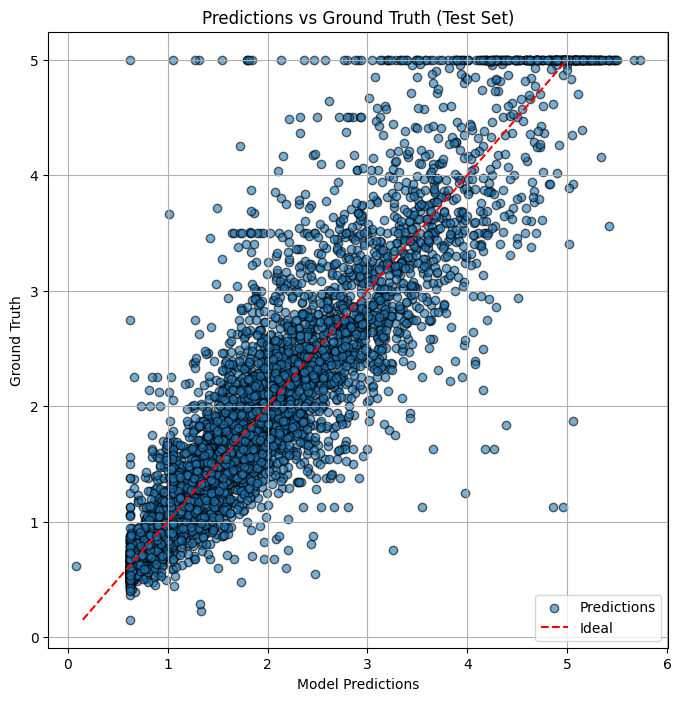

In [86]:
# Scatter plot: Predictions vs Ground Truth
y_test_pred = y_test_pred.flatten()
y_test_true = y_test.flatten()

plt.figure(figsize=(8, 8))
plt.scatter(y_test_pred, y_test_true, alpha=0.6, edgecolors='k', label="Predictions")
plt.plot([y_test_true.min(), y_test_true.max()], [y_test_true.min(), y_test_true.max()], color='red', linestyle='--', label="Ideal")
plt.xlabel("Model Predictions")
plt.ylabel("Ground Truth")
plt.title("Predictions vs Ground Truth (Test Set)")
plt.legend()
plt.grid(True)
plt.show()